In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
import numpy as np

print(tf.__version__)

2.5.0


## 数据加载

In [4]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yudd/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/yudd/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

`num_words = 10000`保留了训练数据最常出现的10000个单词

## 探索数据

每个样本表示的是影评中词汇的整数数组,标签是0/1, 0代表消极,1代表积极

In [5]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


评论的文本被转换为了整数值,其中每个证书代表词典中的一个单词,例如首条评论

In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


由于评论的单词数量并不一定相同,但是神经网络的输入必须是统一的长度,这个问题需要稍后解决,首先看一下第一条和第二条的单词数量

In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

## 将整数转换为单词


In [8]:
# 一个映射单词到整数索引的字典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k: (v + 3) for k,v in word_index.items()}
word_index["<PAD>" ] = 0
word_index["<START>"] = 1
word_index["<UNK>" ] = 2 # unknown
word_index["<UNUSED>"] = 3



reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def decode_review(text):
    return " ".join(
        [reverse_word_index.get(i, "?") for i in text]
    )


In [9]:
decode_review(train_data[1])

"<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

## 准备数据

由于电影评论的长度必须相同,可以使用`pad_sequences`标准化

In [10]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],# 用来补齐的值
                                                       padding="post",
                                                       maxlen = 256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding="post",
                                                       maxlen = 256)

查看样本长度

In [11]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [14]:
print(train_data[0].shape)

(256,)


## 构建模型

In [24]:
## 输入形状是用于电影评论的词汇数目
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation = "relu"))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 损失函数和优化器

由于这是一个二分类问题且模型输出概率值, 使用`bindary_crossentropy`损失函数

In [25]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

### 创建一个验证集

从原始的训练数据中分离出10000个样本来创建一个验证集

In [26]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]


y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 训练模型

以512个样本的minibatch来迭代40个epoch来训练模型,训练过程中,监测验证机的损失率和准确率

In [27]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/40
30/30 [==============================] - 1s 11ms/step - loss: 0.6916 - accuracy: 0.5599 - val_loss: 0.6893 - val_accuracy: 0.6783
Epoch 2/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6853 - accuracy: 0.7271 - val_loss: 0.6803 - val_accuracy: 0.7262
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6709 - accuracy: 0.7609 - val_loss: 0.6625 - val_accuracy: 0.7607
Epoch 4/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6467 - accuracy: 0.7791 - val_loss: 0.6355 - val_accuracy: 0.7746
Epoch 5/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6123 - accuracy: 0.7975 - val_loss: 0.5996 - val_accuracy: 0.7886
Epoch 6/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5695 - accuracy: 0.8164 - val_loss: 0.5581 - val_accuracy: 0.8059
Epoch 7/40
30/30 [==============================] - 0s 7ms/step - loss: 0.5225 - accuracy: 0.8357 - val_loss: 0.5152 - val_accuracy: 0.8208
Epoch 8/40
30/30 [=

## 评估模型

In [28]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

782/782 - 0s - loss: 0.3299 - accuracy: 0.8726
[0.3298547565937042, 0.8726400136947632]


## 创建一个准确率和损失值随时间变化的图表

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

有四个条目,在训练过程中和验证过程中,每个条目对应一个监控指标

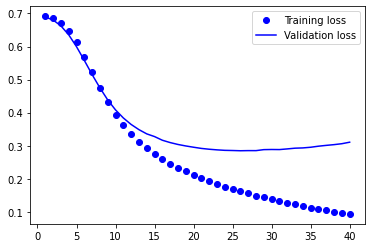

In [31]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
# bo代表蓝点
plt.plot(epochs, loss, 'bo', label = "Training loss")
# b代表蓝色实线
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.legend()
plt.show()

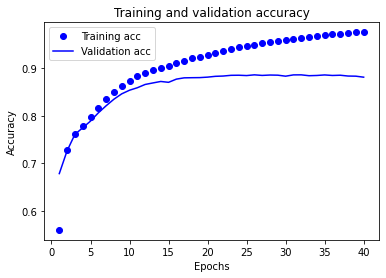

In [32]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

可以看到在epoch = 20时, 验证集loss达到最低,之后有所上升,而准确率保持不变,这表明和这个模型似乎有点过拟合